In [1]:
from pm4py.objects.log.importer.xes import importer as xes_importer
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
import datetime
import random
import time
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt

### Since the data is already converted, I markdowned the cell below. Remember to de-markdown it before submission

#XES TO CSV
xesToCsv_BPI = xes_importer.apply("Datasets/BPI_Challenge_2012.xes")

xesToCsv_listo = []
xesToCsv_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):

    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_attr_list = list(xesToCsv_BPI[i][j])
    
        for k in range(0, len(xesToCsv_attr_list)):
            xesToCsv_prev_attr = xesToCsv_cur_attr
            xesToCsv_cur_attr = xesToCsv_attr_list[k]

            if xesToCsv_cur_attr not in xesToCsv_listo:
                xesToCsv_value = xesToCsv_dic[xesToCsv_prev_attr] + 1
            
                for key in xesToCsv_dic:
                    if xesToCsv_dic[key] >= xesToCsv_value:
                        xesToCsv_dic[key] += 1
            
                xesToCsv_dic[xesToCsv_cur_attr] = xesToCsv_value
                xesToCsv_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
        
        xesToCsv_cur_attr = 'no'
        
        
xesToCsv_chain = []
xesToCsv_event = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    for j in range(0, len(xesToCsv_BPI[i])):
        xesToCsv_chain.append(i)
        xesToCsv_event.append(j)
        
xesToCsv_df_BPI= pd.DataFrame(index=[np.array(xesToCsv_chain), np.array(xesToCsv_event)], columns = xesToCsv_listo)

for i in tqdm(range(0, len(xesToCsv_BPI))):
    
    for j in range(0, len(xesToCsv_BPI[i])):

        xesToCsv_attr = xesToCsv_BPI[i][j]
        
        for a in xesToCsv_attr:
            xesToCsv_df_BPI.loc[(i, j), a] = xesToCsv_attr[a]
            
            
xesToCsv_df_BPI.to_csv('Datasets/BPI_2012.csv')

xesToCsv_attr_listo = []
xesToCsv_attr_dic = {'no': -1}
xesToCsv_prev_attr = 'no'
xesToCsv_counter = 0
xesToCsv_cur_attr = 'no'

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_list = list(xesToCsv_BPI[i].attributes)
    
    for k in range(0, len(xesToCsv_attr_list)):
        xesToCsv_prev_attr = xesToCsv_cur_attr
        xesToCsv_cur_attr = xesToCsv_attr_list[k]

        if xesToCsv_cur_attr not in xesToCsv_attr_listo:
            xesToCsv_value = xesToCsv_attr_dic[xesToCsv_prev_attr] + 1
            
            for key in xesToCsv_attr_dic:
                if xesToCsv_attr_dic[key] >= xesToCsv_value:
                    xesToCsv_attr_dic[key] += 1
            
            xesToCsv_attr_dic[xesToCsv_cur_attr] = xesToCsv_value
            xesToCsv_attr_listo.insert(xesToCsv_value, xesToCsv_cur_attr)
    
    xesToCsv_cur_attr = 'no'
    
    
xesToCsv_attr_chain = []

for i in tqdm(range(0, len(xesToCsv_BPI))):
    xesToCsv_attr_chain.append(i)
    

xesToCsv_df_BPI_attr = pd.DataFrame(index = [np.array(xesToCsv_attr_chain)], columns = xesToCsv_attr_listo)


for i in tqdm(range(0, len(xesToCsv_BPI))):

    xesToCsv_attr = xesToCsv_BPI[i].attributes
    
    for a in xesToCsv_attr:
        xesToCsv_df_BPI_attr.loc[i, a] = xesToCsv_attr[a]
        
xesToCsv_df_BPI_attr.to_csv('Datasets/BPI_attr_2012.csv')

if 'Unnamed: 0' in xesToCsv_df_BPI.columns:
    xesToCsv_df_BPI = xesToCsv_df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    xesToCsv_df_BPI_attr = xesToCsv_df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})

## Data loading:

In [2]:
def fix_time(time):
    return (datetime.datetime.fromisoformat(time))

def load_data(BPI = 'BPI.csv', BPI_attr = 'BPI_attr.csv',  data2012 = False):
    df_BPI = pd.read_csv(BPI)
    df_BPI_attr = pd.read_csv(BPI_attr)
    
    if 'Unnamed: 0' in df_BPI.columns:
        df_BPI = df_BPI.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
        df_BPI_attr = df_BPI_attr.rename(columns={'Unnamed: 0': 'case_id'})
    
    df_BPI['time:timestamp'] = df_BPI['time:timestamp'].apply(fix_time)

    if data2012:
        df_BPI_attr['REG_DATE'] = df_BPI_attr['REG_DATE'].apply(fix_time)
    
    df_BPI['time:weekday'] = [x.weekday() for x in df_BPI['time:timestamp']]
    df_BPI['time:hour'] = [x.hour for x in df_BPI['time:timestamp']]
    return (df_BPI, df_BPI_attr)

def load_data_xes(data):
    BPI = xes_importer.apply(data)
    
df, df_attr = load_data(BPI = 'Datasets/BPI_2012.csv', BPI_attr = 'Datasets/BPI_attr_2012.csv', data2012 = True)
df

,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:weekday,time:hour
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,5,0
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,5,0
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,5,0
3,0,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,5,0
4,0,4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,5,11
5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,5,11
6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,5,11
7,0,7,10862.0,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,5,11
8,0,8,10862.0,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,5,11
9,0,9,10862.0,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,5,11


## Data splitting:

In [ ]:
def data_split(df : pd.DataFrame, df_attr : pd.DataFrame) -> tuple:
    '''Plug in the df and df_attr dataframes'''
    
    splitData_df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    splitData_df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})

    splitData_limit_date = datetime.datetime(2012, 2, 3, 1, 1, 1, 633000, 
                                         tzinfo=datetime.timezone(datetime.timedelta(seconds=7200)))

    #training data_set
    splitData_df_train = splitData_df
    splitData_listo = []
    
    print(splitData_df)

    for i in tqdm(range(0, 13087)):
        if splitData_df[splitData_df['case_id'] == i].iloc[-1]['time:timestamp'] > splitData_limit_date:
            splitData_listo.append(i)

    for i in tqdm(range(0, len(splitData_listo))):
        splitData_df_train = splitData_df_train.drop(splitData_df_train[splitData_df_train['case_id'] == splitData_listo[i]].index)

    splitData_df_train = splitData_df_train.reset_index(drop = True)

    #testing data_set
    splitData_df_test = pd.DataFrame(columns = (splitData_df.columns))
    splitData_listo = []

    for i in tqdm(range(0, 13087)):
        if splitData_df[splitData_df['case_id'] == i].iloc[0]['time:timestamp'] > splitData_limit_date:
            splitData_listo.append(i)

    for i in tqdm(range(0, len(splitData_listo))):
        splitData_df_test = splitData_df_test.append(splitData_df[splitData_df['case_id'] == splitData_listo[i]])

    splitData_df_test = splitData_df_test.reset_index(drop = True)
    
    return(splitData_df_train, splitData_df_test)

Warning, the code below takes around 9 minutes to run. There will be four loading sliders in total

In [ ]:
df_train, df_test = data_split(df, df_attr)

In [ ]:
df_train.to_csv('trainExample.csv')

df_test.to_csv('testExample.csv')

#### Just for usage purposes, load here the pre-created train/test sets. This is a non-release feature only for notebook swifter manipulation and shall be markdowned/deleted before submission:

In [ ]:
df_train, df_test = pd.read_csv('trainExample.csv'), pd.read_csv('testExample.csv')

## Baseline:

In [ ]:
def load_dataset_csv(file_name : str, file_attribute_name : str) -> list:
    '''Loading the two datasets. So far we'll only be using the BPI.csv one
    This also parses the date column'''
    
    df = pd.read_csv(file_name)
    df['time:timestamp'] = df['time:timestamp'].apply(fix_time)
    df_attr = pd.read_csv(file_attribute_name)
    return (df, df_attr)

#Do we even need this now? def load_data is there above and they don't seen to be too different
#I'm leaving this one so far - better not to erase in doubt

In [ ]:
# The current version of the tool works with the 2012 dataset!!!
baseline_df, baseline_df_attr = load_dataset_csv('Datasets/BPI_2012.csv', 'Datasets/BPI_attr_2012.csv')

#Let us change the column names to the aforementioned
baseline_df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
       'concept:name', 'time:timestamp']

#Erasing all the non-complete actions from the database:
baseline_df = baseline_df[baseline_df['lifecycle:transition'] == 'COMPLETE']

baseline_df = baseline_df.reset_index(drop=True)

def compute_time_difference(baseline_df : pd.DataFrame):
    '''Set the time difference column
    This function is places here because of the erased non-complete actions
    
    It has been a no-input, no-return function, so I fixed this ~ Rav'''

    baseline_df['time:time_between'] = baseline_df['time:timestamp'].diff()
    baseline_df.loc[baseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
    
    return(baseline_df)
    
baseline_df = compute_time_difference(baseline_df)

def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    
    dic_occurrence = {}
    dic_total_time = {}
    ids = list(df['case_id']) + ['editor: last id'] #Otherwise we check i+1-th position that does not exist
    times = list(df['time:time_between']) + [pd.Timedelta(0)] #Otherwise we check i+1-th position that does not exist
    names = df['concept:name']
    df_concept = df[names == concept_name]
    
    for i, row in df_concept.iterrows():
        
        if (ids[i] == ids[i+1]): #an instance of the same case
            
            if (names[i+1] not in dic_occurrence):
                dic_occurrence[names[i+1]] = 1
                dic_total_time[names[i+1]] = times[i+1]
            else:
                dic_occurrence[names[i+1]] += 1
                dic_total_time[names[i+1]] += times[i+1]
                
        else: #the last instance of the case
            
            if ('editor: close_case' not in dic_occurrence):
                dic_occurrence['editor: close_case'] = 1
                dic_total_time['editor: close_case'] = times[i+1]
            else:
                dic_occurrence['editor: close_case'] += 1
                dic_total_time['editor: close_case'] += times[i+1]
    
    #Compute average time
    dic_avg_time = {}
    
    for key in dic_total_time:
        dic_avg_time[key] = dic_total_time[key] / dic_occurrence[key]
        
    return(dic_occurrence, dic_avg_time)

creating_dict_for_next_step_stats(baseline_df, 'A_SUBMITTED')

def choosing_next_action(dic : dict):
    '''Finds the max value of the input dict and returns the key of the max value'''
    
    max_key = max(dic, key=dic.get)
    return(max_key)


def cycles_shortcut(actions : list, concept_name : str, max_length : int, printing = False) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            if (pritning):
                print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            if (printing):
                print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

def iterating_expected_actions(df : pd.DataFrame, concept_name : str, n : int) -> list:
    '''concept_name is the starting point (first action)
    n is the length of the longest trace ever observed
    It is stored in lonest_trace but for runtime reasons, use n so far'''
    
    longest_trace = max(df['step_number']) #finding the longest trace in the database (nr of steps)
    #note that we determine this AFTER deleting some rows with uncomplete steps. We should be running this on full df
    
    i = 0
    actions = [concept_name] #Here is the list that will store all the subsequent actions the algorithm decices to perform
    while (i < n): #terminate if we are exceeding the max number of steps
        wow = creating_dict_for_next_step_stats(df, concept_name)[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        
        if(cycles_shortcut(actions, concept_name, n) != False): #Checks if we are stuck in a loop
            print("we are stuck in a loop")
            return(cycles_shortcut(actions, concept_name, n))
        
        if(concept_name == 'editor: close_case'): #If it is the "terminate" option - terminate
            break
        actions.append(concept_name) #Add the action to the list
        i += 1
    
    actions.append('editor: close_case')
    #print('i = ', i, "n = ", n)
    
    return(actions)

def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['concept:name'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    
    for event in all_events:
        next_step_stats = creating_dict_for_next_step_stats(df, event)
        wow = next_step_stats[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        next_event_name_dic[event] = concept_name
        next_event_duration_dic[event] = next_step_stats[1][concept_name]
    
    return next_event_name_dic, next_event_duration_dic

#Get list of all expected next events and the expected time till that next event
baseline_all_expected_events = add_expected_events(baseline_df)

#Add column to dataframe with expected next events and times
baseline_df['expect:next_event'] = baseline_df['concept:name'].map(baseline_all_expected_events[0])
baseline_df['expect:next_time'] = baseline_df['concept:name'].map(baseline_all_expected_events[1]) + baseline_df['time:timestamp']

baseline_df.to_csv('BPI_with_predictions.csv')

iterating_expected_actions(baseline_df, 'A_SUBMITTED', 15)

## Baseline's performance testing:

Set sample datasets of the below sizes to test the runtime of any algorithm on them:

In [ ]:
baseline_limits = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
baseline_runtimes = [0] * len(baseline_limits)

for i in range(0, len(baseline_limits)):
    print(i)
    df_small = baseline_df[:baseline_limits[i]]
    time_start = time.time()
    iterating_expected_actions(df_small, 'A_SUBMITTED', 15)
    time_end = time.time()
    baseline_runtimes[i] = time_end-time_start
    
baseline_runtimes

Plotting its runtimes:

In [ ]:
baseline_wow = plt.figure(figsize=(7.5, 5))
plt.scatter(x = baseline_limits, y=baseline_runtimes, color = '#AB3334')
plt.title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
plt.ylabel('Operating time [log(s)]', fontsize = 13)
plt.xlabel('Input size [log(n)]', fontsize = 13)
plt.xscale("log")
plt.yscale('log')

baseline_wow2 = plt.figure(figsize=(7.5, 5))
plt.scatter(x = baseline_limits, y=baseline_runtimes, color = '#420CDA')
plt.title('Runtime of the baseline algorithm', fontsize = 16)
plt.ylabel('Operating time [s]', fontsize = 13)
plt.xlabel('Input size [n]', fontsize = 13)

baseline_f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.scatter(x = baseline_limits, y=baseline_runtimes, color = '#420CDA')
ax1.set_title('Runtime of the baseline algorithm', fontsize = 16)
ax1.set_xlabel('Input size [n]', fontsize = 13)
ax1.set_ylabel('Operating time [s]', fontsize = 13)

ax2.scatter(x = baseline_limits, y=baseline_runtimes, color = '#AB3334')
ax2.set_title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
ax2.set_ylabel('Operating time [log(s)]', fontsize = 13)
ax2.set_xlabel('Input size [log(n)]', fontsize = 13)
ax2.set_xscale("log")
ax2.set_yscale('log')

baseline_f

### Assessing the accuracy of predictions:

In [ ]:
#Testing the Baseline
testingBaseline_df = df.rename(columns={'Unnamed: 0': 'case_id', 'Unnamed: 1': 'step_number'})
    
testingBaseline_df_attr = df_attr.rename(columns={'Unnamed: 0': 'case_id'})

testingBaseline_df = testingBaseline_df[testingBaseline_df['lifecycle:transition'] == 'COMPLETE']
testingBaseline_df = testingBaseline_df.reset_index(drop = True)

testingBaseline_df['time:time_between'] = testingBaseline_df['time:timestamp'].diff()
testingBaseline_df.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

#amount of total data that is training data:
testingBaseline_train_data = 0.8
#amount of train data that is validation data:
testingBaseline_validation_data = 0.1

testingBaseline_limit_date = testingBaseline_df[testingBaseline_df['case_id'] == round(testingBaseline_df.iloc[-1, 0]*testingBaseline_train_data)].iloc[0]['time:timestamp']
#limit_date = datetime.datetime(2012, 2, 3, 1, 1, 1, 633000, tzinfo=datetime.timezone(datetime.timedelta(seconds=7200))) 

#training data_set
testingBaseline_df_train = testingBaseline_df
testingBaseline_listo = []

for i in tqdm(range(0, 13087)):
    if testingBaseline_df[testingBaseline_df['case_id'] == i].iloc[-1]['time:timestamp'] > testingBaseline_limit_date:
        testingBaseline_listo.append(i)

for i in tqdm(range(0, len(testingBaseline_listo))):
    testingBaseline_df_train = testingBaseline_df_train.drop(testingBaseline_df_train[testingBaseline_df_train['case_id']==testingBaseline_listo[i]].index)

testingBaseline_df_train = testingBaseline_df_train.reset_index(drop = True)

#splitting training dataset into validation and training dataset
testingBaseline_mask = np.random.rand(len(testingBaseline_df_train)) < testingBaseline_validation_data
testingBaseline_df_validation = testingBaseline_df_train[testingBaseline_mask]
testingBaseline_df_train = testingBaseline_df_train[~testingBaseline_mask]

#testing data_set
testingBaseline_df_test = pd.DataFrame(columns = (testingBaseline_df.columns))
testingBaseline_listo = []

for i in tqdm(range(0, 13087)):
    if testingBaseline_df[testingBaseline_df['case_id'] == i].iloc[0]['time:timestamp'] > testingBaseline_limit_date:
        testingBaseline_listo.append(i)

for i in tqdm(range(0, len(testingBaseline_listo))):
    testingBaseline_df_test = testingBaseline_df_test.append(testingBaseline_df[testingBaseline_df['case_id'] == testingBaseline_listo[i]])

testingBaseline_df_test = testingBaseline_df_test.reset_index(drop = True)

testingBaseline_df_train.to_csv('BPI_2012_train', index=False)

testingBaseline_df_validation.to_csv('BPI_2012_validation')

testingBaseline_df_test.to_csv('BPI_2012_test', index=False)

In [ ]:
testingBaseline_df_train = pd.read_csv('BPI_2012_train')
testingBaseline_df_train['time:timestamp'] = testingBaseline_df_train['time:timestamp'].apply(fix_time)
testingBaseline_df_train['time:time_between'] = testingBaseline_df_train['time:timestamp'].diff()
testingBaseline_df_train.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

testingBaseline_df_test = pd.read_csv('BPI_2012_test')
testingBaseline_df_test['time:timestamp'] = testingBaseline_df_test['time:timestamp'].apply(fix_time)
testingBaseline_df_test['time:time_between'] = testingBaseline_df_test['time:timestamp'].diff()
testingBaseline_df_test.loc[testingBaseline_df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)

#creates column with predicted data
def prediction(prev):
    return baseline_all_expected_events[0][prev]

testingBaseline_df_test['predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#function that creates the 'correct' using a dataframe, the predcting column and the true column, it shows wether the prediction was correct
testingBaseline_df_test['shifted_actual'] = testingBaseline_df_test['concept:name'].shift(-1)
testingBaseline_df_test['shifted_case_id'] = testingBaseline_df_test['case_id'].shift(-1)
    
def apply_function(var):
    if var[2] == var[3]:
        return (var[0] == var[1])
        
    else:
        return (var[0] == 'editor:close_case')
        
testingBaseline_df_test['correct'] = testingBaseline_df_test[['predicted', 'shifted_actual', 'case_id', 'shifted_case_id']].apply(apply_function, axis=1)
testingBaseline_df_test = testingBaseline_df_test.drop(['shifted_actual', 'shifted_case_id'], axis=1)

def prediction(prev):
    return baseline_all_expected_events[1][prev]

testingBaseline_df_test['time:between_predicted'] = testingBaseline_df_test['concept:name'].apply(prediction)

#create column with absolute difference between predicted time and actual time
def time_difference(var):
    return abs((var[0] - var[1]).total_seconds())

def time_difference_if_correct(var):
    if var[0]:
        return abs((var[1] - var[2]).total_seconds())
    else:
        return 0

testingBaseline_df_test['time:absolute_predicton_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:absolute_predicton_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)
    

testingBaseline_df_test['time:relative_predicton_off'] = testingBaseline_df_test[['time:time_between', 'time:between_predicted']].apply(time_difference, axis=1)
testingBaseline_df_test['time:relative_predicton_correct'] = testingBaseline_df_test[['correct', 'time:time_between', 'time:between_predicted']].apply(time_difference_if_correct, axis=1)

#mean of the absolute time
seconds = testingBaseline_df_test['time:absolute_predicton_off'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = testingBaseline_df_test['time:absolute_predicton_correct'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

#median of the absolute time
seconds = testingBaseline_df_test['time:absolute_predicton_off'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = testingBaseline_df_test['time:absolute_predicton_correct'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

testingBaseline_df_test['time:absolute_predicton_off'].hist(bins=10)

#mean of the relative time
seconds = testingBaseline_df_test['time:relative_predicton_off'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = testingBaseline_df_test['time:relative_predicton_correct'].mean()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

#median of the relative time
seconds = testingBaseline_df_test['time:relative_predicton_off'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

seconds = testingBaseline_df_test['time:relative_predicton_correct'].median()
minutes = seconds/60
hours = minutes/60
days = hours/24
print(str(seconds) + ', ' + str(minutes) + ', ' + str(hours) + ', ' + str(days))

testingBaseline_df_test['time:relative_predicton_off'].hist(bins=10)

In [3]:
NR_OF_CLUSTERS = 15

In [4]:
def prepare_column_for_clustering(case_id_column, cluster_column, unique_values):
    cluster_column = cluster_column.fillna(-1)
    grouped_df = pd.DataFrame({'case_id': case_id_column, 'column': cluster_column})
    
    for val in unique_values:
        grouped_df[val] = 0
        grouped_df.loc[grouped_df['column'] == val, val] = 1
    
    return grouped_df[['case_id'] + list(unique_values)]

In [5]:
def get_clusters(prepared_rows):
    kmeans = KMeans(n_clusters=NR_OF_CLUSTERS)
    
    unique_columns = list(prepared_rows.columns)
    unique_columns.pop(0)

    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    kmeans.fit(df_grouped[unique_columns])
    prediction = kmeans.labels_
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))}), kmeans

In [ ]:
def get_tree(df_train, cluster_one, mapping):
    model = RandomForestClassifier(n_estimators=100, max_depth=10)
    special_df = df_train.copy()
    
    special_df['next_event int'] = special_df['next_event'].map(mapping)
    
    X_dtc = special_df[[cluster_one, 'step_number', 'time:weekday', 'time:hour']].copy()
    y_dtc = special_df[['next_event int']]

    model.fit(X_dtc, y_dtc['next_event int'])
    
    return model

In [ ]:
def predict_clusters(cluster_model, prepared_rows, unique_columns):
    df_grouped = prepared_rows.groupby('case_id')[unique_columns].sum()
    prediction = cluster_model.predict(df_grouped[unique_columns])
    unique_case_ids = prepared_rows['case_id'].unique()
    return prepared_rows.case_id.map({unique_case_ids[i]: prediction[i] for i in range(len(prediction))})

In [ ]:
def predict_value(tree, df_predict, cluster_one, reverse_mapping):
    X_dtc = df_predict[[cluster_one, 'step_number', 'time:weekday', 'time:hour']]
    
    prediction = tree.predict(X_dtc)
    return np.vectorize(reverse_mapping.get)(prediction)

In [ ]:
def cluster_tree_predict(df_train, df_test):
    cluster_tree_train, cluster_tree_test = df_train.copy(), df_test.copy()
    
    cluster_tree_train["next_event"] = cluster_tree_train["concept:name"]
    cluster_tree_train.loc[cluster_tree_train['step_number'] == 0, 'next_event'] = 'editor: close_case'
    cluster_tree_train["next_event"] = cluster_tree_train["next_event"].shift(-1)
    cluster_tree_train.loc[len(cluster_tree_train) - 1, 'next_event'] = 'editor: close_case'
    
    cluster_tree_test["next_event"] = cluster_tree_test["concept:name"]
    cluster_tree_test.loc[cluster_tree_test['step_number'] == 0, 'next_event'] = 'editor: close_case'
    cluster_tree_test["next_event"] = cluster_tree_test["next_event"].shift(-1)
    cluster_tree_test.loc[len(cluster_tree_test) - 1, 'next_event'] = 'editor: close_case'
    
    mapping, reverse_mapping = {}, {}
    all_events = ['editor: close_case'] + list(cluster_tree_train['concept:name'].unique())

    for i in range(len(all_events)):
        mapping[all_events[i]] = i
        reverse_mapping[i] = all_events[i]
    
    #Clustering
    unique_values = cluster_tree_train['concept:name'].unique()
    prepared_train_data = prepare_column_for_clustering(cluster_tree_train['case_id'], cluster_tree_train['concept:name'], unique_values)
    cluster_tree_train['concept:name cluster'], cluster_model = get_clusters(prepared_train_data)
    
    prepared_test_data = prepare_column_for_clustering(cluster_tree_test['case_id'], cluster_tree_test['concept:name'], unique_values)
    cluster_tree_test['concept:name cluster'] = predict_clusters(cluster_model, prepared_test_data, unique_values)
    
    for i in range(NR_OF_CLUSTERS):
        clustered_train_df = cluster_tree_train[cluster_tree_train['concept:name cluster'] == i]
        tree_model = get_tree(clustered_train_df, 'concept:name cluster', mapping)
        
        clustered_test_df = cluster_tree_test[cluster_tree_test['concept:name cluster'] == i]
        if clustered_test_df.size > 0:
            cluster_tree_test.loc[cluster_tree_test['concept:name cluster'] == i, 'predicted'] = predict_value(tree_model, clustered_test_df, 'concept:name cluster', reverse_mapping)
    
    return cluster_tree_test
    
cluster_tree_predict(df_train, df_test)

### Visualizations

In [6]:
from sklearn.decomposition import PCA
from random import randint
import seaborn as sns

In [7]:
#Group pre-cluster df by case (case_id)
precluster_df = prepare_column_for_clustering(df['case_id'], df['concept:name'], df['concept:name'].unique())
precluster_df_by_case = precluster_df.groupby('case_id').sum()
precluster_df_by_case.head()

,A_SUBMITTED,A_PARTLYSUBMITTED,A_PREACCEPTED,W_Completeren aanvraag,A_ACCEPTED,O_SELECTED,A_FINALIZED,O_CREATED,O_SENT,W_Nabellen offertes,...,O_ACCEPTED,A_ACTIVATED,O_CANCELLED,W_Wijzigen contractgegevens,A_DECLINED,A_CANCELLED,W_Afhandelen leads,O_DECLINED,W_Nabellen incomplete dossiers,W_Beoordelen fraude
case_id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,3,1,1,1,1,1,7,...,1,1,0,0,0,0,0,0,0,0
1,1,1,1,5,1,2,1,2,2,10,...,1,1,1,0,0,0,0,0,0,0
2,1,1,1,9,1,3,1,3,3,25,...,1,1,2,1,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
#Perform PCA (2 component) on the data
pca = PCA(n_components = 2)
pca.fit(precluster_df_by_case)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [10]:
#Create principle components
pca_df = pd.DataFrame(pca.transform(precluster_df_by_case))
pca_df.index.names = ['case_id']
pca_df.head()

,0,1
case_id,,
0,0.776662,-1.766118
1,4.483221,-3.996394
2,13.335660,-14.378924
3,-5.451243,3.194374
4,-5.451243,3.194374


In [11]:
df['concept:name cluster'], cluster_model = get_clusters(precluster_df)

In [12]:
#Group regular df by case (case_id)
df_by_case = df.groupby('case_id').mean()[['concept:name cluster']]
df_by_case.head()

,concept:name cluster
case_id,
0,8.0
1,8.0
2,3.0
3,10.0
4,10.0


In [13]:
#Merge the dataframes
vis_df = pd.merge(df_by_case, pca_df, on='case_id', how='left')
vis_df.columns = ['cluster', 'x_comp', 'y_comp']
vis_df.head()

,cluster,x_comp,y_comp
case_id,,,
0,8.0,0.776662,-1.766118
1,8.0,4.483221,-3.996394
2,3.0,13.335660,-14.378924
3,10.0,-5.451243,3.194374
4,10.0,-5.451243,3.194374


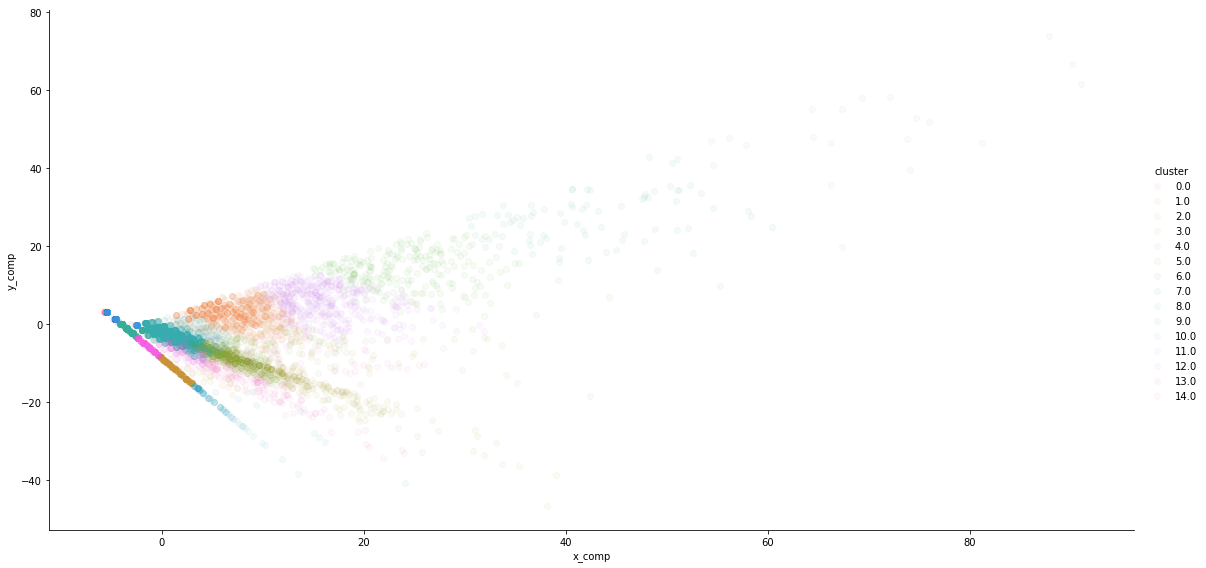

In [14]:
#Plot with low alpha
sns.lmplot('x_comp', 'y_comp', data=vis_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.05})

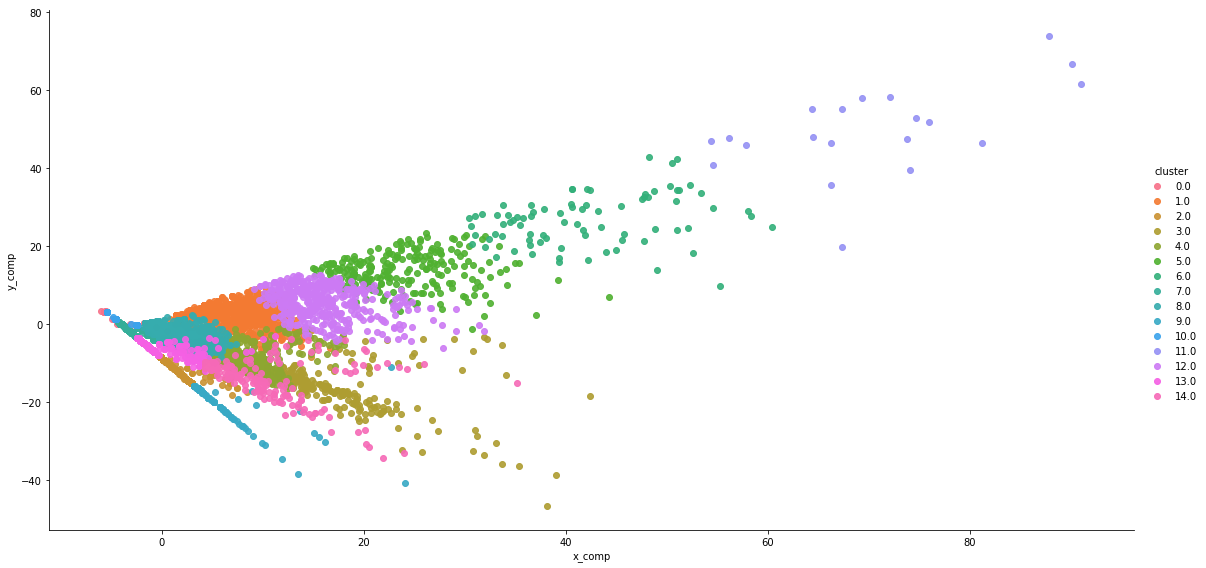

In [15]:
#Plot with high alpha
sns.lmplot('x_comp', 'y_comp', data=vis_df, hue='cluster', fit_reg=False, height=8, aspect=2, scatter_kws={'alpha': 0.9})